In [1]:
import os.path
import glob
import pandas as pd
from biom import Table, load_table

import warnings

from qiime2.plugins.feature_table.methods import (rarefy, filter_samples, filter_features,
                                                  filter_features_conditionally, merge,rename_ids,group)
from qiime2.plugins.feature_table.visualizers import summarize

from qiime2 import Artifact
from qiime2 import Metadata


from skbio import OrdinationResults, TreeNode, DistanceMatrix
import skbio
from qiime2.plugins.gemelli.actions import (rpca, phylogenetic_rpca_without_taxonomy,
                                            phylogenetic_rpca_with_taxonomy)
from qiime2.plugins.emperor.actions import plot, biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.pipelines import (alpha,
                                                alpha_phylogenetic)
from qiime2.plugins.diversity.visualizers import (alpha_rarefaction,adonis,beta_group_significance)
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins import taxa

from qiime2.plugins import emperor

from skbio.stats.distance import permanova, bioenv
import statsmodels.stats.multitest as multi 
from scipy.optimize import curve_fit
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import re
import sys

from statannotations.Annotator import Annotator


In [2]:
# classifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import (roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
# stats
from statsmodels.stats.contingency_tables import mcnemar
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

# Importing files

In [3]:
gg2_ft = Artifact.load('./data/katharo_deblur_gg2_feature_table.qza')

In [4]:
#feature (sOTU) counts 
gg2_ft.view(pd.DataFrame).sum().sum()

14215301.0

In [5]:
#matrix shape, features x samples
gg2_ft.view(Table)

10892 x 464 <class 'biom.table.Table'> with 86054 nonzero entries (1% dense)

In [6]:
gg2_taxonomy = Artifact.load('./data/gg2_taxonomy.qza')

In [7]:
gg2_taxonomy_df = gg2_taxonomy.view(pd.DataFrame)

### !!! NEED TO DOWNLOAD Greengenes2 tree !!!

In [8]:
## Need to download Greengenes2 tree from FTP
## https://ftp.microbio.me/greengenes_release/2022.10/
## Place in ./data/ folder
gg2_tree = Artifact.load('./data/2022.10.phylogeny.asv.nwk.qza')

### ^           ^           ^           ^           ^           ^           ^           ^           ^

In [9]:
##Updated. Need to update metadata in Qiita study
metadata = Metadata.load('./metadata/2023_03_21_3DMM_metadata_to_update_qiita.txt')

In [10]:
gg2_feature_metadata = Metadata.load('./metadata/gg2_taxonomy.tsv')

In [11]:
metadata_df = metadata.to_dataframe()

In [12]:
module_colors= {'Airlock':'tab:red',
               'Columbus':'tab:blue',
               'JLP':'tab:orange',
               'JPM':'tab:green',
               'US Lab':'cadetblue',
               'Node 1':'tab:purple',
               'Node 2':'yellow',
               'Node 3':'tab:cyan',
               'PMM':'tab:pink'}

# Alpha Diversity

In [13]:
## Takes a while to run. Computed once and saved to file for reference. 
# alpha_rare_curve = alpha_rarefaction(gg2_ft,
#                                      phylogeny = gg2_tree,
#                                      metadata = metadata,
#                                      max_depth = 15000,
#                                      steps=15)

In [14]:
# alpha_rare_curve.visualization.save('./output/alpha_rarefaction_curve.qzv')

In [15]:
#Katharo
summarize(gg2_ft,metadata).visualization.save('./output/katharo_deblur_gg2_feature_table_summary.qzv')

'./output/katharo_deblur_gg2_feature_table_summary.qzv'

At a 5000 rarefaction depth 15.93% of the features and 97.63% of the samples (after katharoseq filtering) are retained. Alpha rarefaction curves start to plateau between 2000-4000 read counts, and alpha rarefaction trends de-stabilize after 6000 reads as a significant proportion of samples start dropping out. 

In [16]:
#Rarefied once and saved to file. 
#Because of random nature of rarefaction, subsequent rarefied tables might have slightly different results
# deblur_gg2_no_controls_rarefied = rarefy(deblur_gg2_no_controls,
#                             sampling_depth=5000).rarefied_table
# deblur_gg2_no_controls_rarefied.save('./data/katharo_deblur_gg2_feature_table_no_controls_rarefied.qza')
deblur_gg2_no_controls_rarefied = Artifact.load('./data/katharo_deblur_gg2_feature_table_no_controls_rarefied.qza')

In [17]:
deblur_gg2_no_controls_rarefied.view(Table)

6467 x 384 <class 'biom.table.Table'> with 62076 nonzero entries (2% dense)

In [18]:
deblur_gg2_no_controls_rarefied.view(pd.DataFrame).sum().sum()

1920000.0

## Saturation of feature space with increasing sampling depth

In [19]:
ft_df = gg2_ft.view(pd.DataFrame)

In [20]:
# .01% abundance filter and %.5% prevalnce filter (feature must appear it at least 2 samples)
ft_df = filter_features_conditionally(gg2_ft,abundance=.0001,prevalence=.005).filtered_table.view(pd.DataFrame)

In [21]:
# Simple observed features saturation dataframe for plot
saturation = pd.DataFrame(index=range(ft_df.shape[0]))
counts=0
feature_space = set()
sample_space = list()
for n_,sample_ in zip(range(ft_df.shape[0]),ft_df.index):
    m_ = set(ft_df.loc[sample_,ft_df.loc[sample_,:]>0].index)
    counts_ = ft_df.loc[sample_,ft_df.loc[sample_,:]>0].sum()
    feature_space.update(m_)
    saturation.loc[n_,'features']=len(feature_space)
    counts += counts_
    saturation.loc[n_,'counts']=counts
    sample_space.append(sample_)

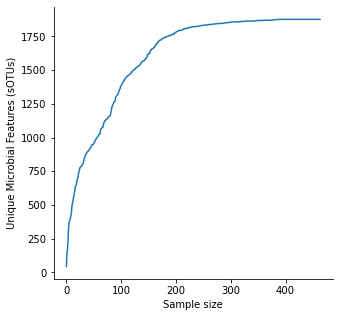

In [22]:
#Fig S1C
f, ax = plt.subplots(ncols=1,figsize=(5,5),sharey=True)
sns.lineplot(x=saturation.index,y=saturation['features'],ax=ax)
ax.set_ylabel('Unique Microbial Features (sOTUs)')
ax.set_xlabel('Sample size')



ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

In [23]:
#Loading metabolomics sirius feature table (qiime2 artifact)
mb_pos_ft = Artifact.load('./data/20220314_3DMM_pos_feature-table-hashed_sirius5.qza')
mb_pos_df = mb_pos_ft.view(pd.DataFrame)
mb_pos_df.shape

(786, 9135)

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

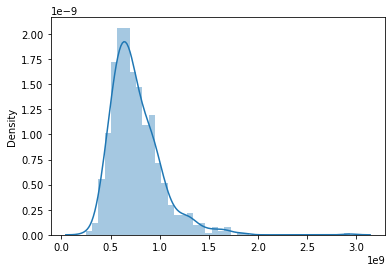

In [24]:
sns.distplot(mb_pos_df.sum(axis=1))

In [25]:
mb_pos_df.shape

(786, 9135)

In [26]:
# Simple observed features saturation dataframe for plot
saturation_mb = pd.DataFrame(index=range(mb_pos_df.shape[0]))
counts=0
feature_space = set()
sample_space = list()
for n_,sample_ in zip(range(mb_pos_df.shape[0]),mb_pos_df.index):
    m_ = set(mb_pos_df.loc[sample_,mb_pos_df.loc[sample_,:]>0].index)
    counts_ = mb_pos_df.loc[sample_,mb_pos_df.loc[sample_,:]>0].sum()
    feature_space.update(m_)
    saturation_mb.loc[n_,'features']=len(feature_space)
    counts += counts_
    saturation_mb.loc[n_,'counts']=float(counts)
    sample_space.append(sample_)

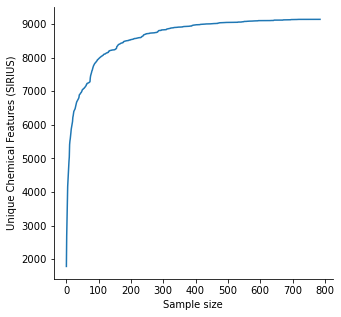

In [27]:
#Fig S1D
f, ax = plt.subplots(ncols=1,figsize=(5,5),sharey=True)
sns.lineplot(x=saturation_mb.index,y=saturation_mb['features'],ax=ax)

ax.set_ylabel('Unique Chemical Features (SIRIUS)')
ax.set_xlabel('Sample size')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

In [28]:
#Calculating alpha diversity results for non-phylogenetic metrics
alpha_metrics = ['shannon','observed_features']
#Storing qiime2 artifact results in a dictionary
alpha_div = {}
#Storing numeric results in a dataframe
alpha_results_df = pd.DataFrame([])
for metric in alpha_metrics:
    alpha_results = alpha(deblur_gg2_no_controls_rarefied,
         metric=metric).alpha_diversity
    alpha_div.update({metric:alpha_results})
    alpha_results_df[metric] = alpha_results.view(pd.Series)

In [29]:
#Calculating alpha diversity results for phylogenetic metric
alpha_phylogenetic_results = alpha_phylogenetic(deblur_gg2_no_controls_rarefied,gg2_tree,
                                               metric='faith_pd').alpha_diversity
alpha_div.update({'faith_pd':alpha_phylogenetic_results})
#Storing numeric results in a dataframe
alpha_results_df['faith_pd'] = alpha_phylogenetic_results.view(pd.Series)

In [30]:
#Merging alpha diversity results with metadata for plotting
alpha_results_df_w_metadata = pd.merge(metadata_df,alpha_results_df,
                                       how='right',left_index=True,right_index=True)

#Sorting for plotting consistency
sorter = ['Airlock', 'Columbus', 'JLP', 'JPM', 'US Lab', 'Node 1', 'Node 2','Node 3', 'PMM']
alpha_results_df_w_metadata['module'] = alpha_results_df_w_metadata['module'].astype("category")
alpha_results_df_w_metadata.module.cat.set_categories(sorter, inplace=True)
alpha_results_df_w_metadata.sort_values(by='module',inplace=True)

In [31]:
#Importing metabolomics alpha diversity
mb_alpha = Artifact.load('./data/mb-phylogenetic-alpha-diversity.qza')
mb_pos_metadata_df = pd.read_csv('./metadata/20221018_metadata_pos.txt',sep='\t')
#Cleaning up dataframes
mb_pos_metadata_df.rename(columns={'filename':'sample_name'},inplace=True)
mb_pos_metadata_df = mb_pos_metadata_df.set_index('sample_name')
mb_pos_metadata = Metadata(mb_pos_metadata_df) #makes qiime2 metadata artifact
#Merging metabolomics alpha diversity results with metadata
mb_metadata_walpha = pd.DataFrame(mb_alpha.view(pd.Series)).merge(mb_pos_metadata_df,
                                                                  left_index=True,right_index=True,how='left')
#Cleaning up merged metabolomics dataframe
mb_metadata_walpha.rename(columns={'faith_pd':'mb_faith_pd'},inplace=True)
mb_metadata_walpha['ATTRIBUTE_Labels'] = mb_metadata_walpha['ATTRIBUTE_Labels'].apply(lambda x: x.strip())

In [32]:
#merging metabolomics and microbial alpha diversity for plotting
alpha_merged = alpha_results_df_w_metadata.merge(mb_metadata_walpha,left_on='labels',right_on='ATTRIBUTE_Labels',how='left')

Text(0, 0.5, 'Microbial phylogenetic diveristy')

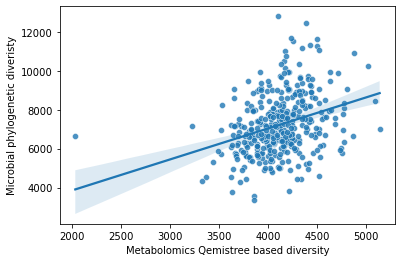

In [33]:
#Fig. S5L
sns.regplot(x='mb_faith_pd',y='faith_pd',data=alpha_merged,scatter=False)
sns.scatterplot(x='mb_faith_pd',y='faith_pd',data=alpha_merged,alpha=0.8)
plt.xlabel('Metabolomics Qemistree based diversity')
plt.ylabel('Microbial phylogenetic diveristy')

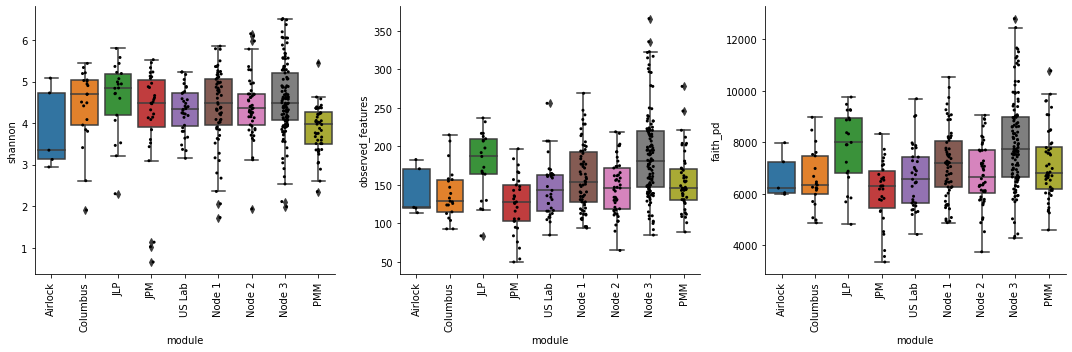

In [34]:
# Alpha diversity visualization 
metrics_viz = ['shannon','observed_features','faith_pd']
##setup subplots, 3 metrics so 2 columns by 2 rows
index=0
rows=1
columns=3
metadata_cat = 'module'
f, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,5))
plt.subplots_adjust(hspace=0.5)
for metric,axs in zip(metrics_viz,axes):
    sns.boxplot(x=metadata_cat, y=metric, data=alpha_results_df_w_metadata,
                ax=axs)
    sns.stripplot(x=metadata_cat, y=metric, data=alpha_results_df_w_metadata,
                ax=axs,size=3,color='black')
    labels = axs.get_xticklabels()
    axs.set_xticklabels(labels,rotation=90, ha='center')
    index += 1
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
plt.tight_layout()

In [35]:
#calculates median for sorting
for metric in ['shannon', 'observed_features', 'faith_pd']:
    for group in alpha_results_df_w_metadata['module'].unique():
        median_ = alpha_results_df_w_metadata.loc[alpha_results_df_w_metadata['module']==group,
                                                  metric].median()
        alpha_results_df_w_metadata.loc[alpha_results_df_w_metadata['module']==group,
                                        str(metric)+'_median']=median_

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Node 1 vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.817e-03 U_stat=2.548e+03
US Lab vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.927e-01 U_stat=8.110e+02
PMM vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.498e-04 U_stat=1.720e+03
Columbus vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.848e-01 U_stat=4.215e+02
US Lab vs. Node 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.285e-01 U_stat=8.970e+02
JPM vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.228e-02 U_stat=4.970e+02
Airlock vs. Node 1: Mann-Whitney-Wilcoxon test two-sided with 

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


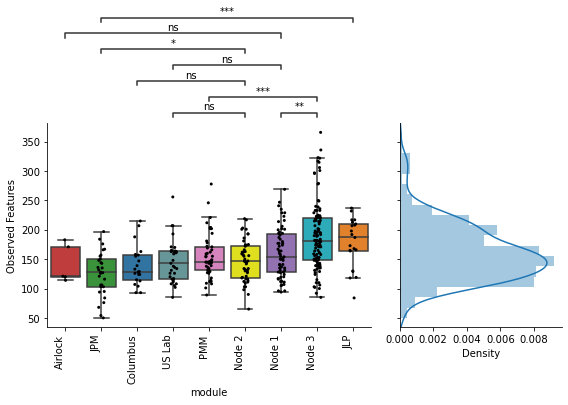

In [36]:
#Fig. S2A
#Alpha diversity figure with stat tests
f, (ax1,ax2) = plt.subplots(ncols=2,figsize=(8,7),gridspec_kw={'width_ratios': [2, 1]},sharey=True)
order_ = alpha_results_df_w_metadata.sort_values(by='observed_features_median')['module'].unique()
sns.boxplot(x='module', y='observed_features', order=order_,data=alpha_results_df_w_metadata, fliersize=0,
            ax=ax1,palette=module_colors)
sns.stripplot(x='module', y='observed_features', order=order_,data=alpha_results_df_w_metadata,
              size=3,color='black',ax=ax1)

#pairs for stat tests were defined by physical interconnectedness of modules 

pairs = [('JPM','JLP'),('Node 3','PMM'),('Node 2','JPM'),('Node 2','Columbus'),('Node 2','US Lab'),
        ('Node 1','US Lab'),('Airlock','Node 1'),('Node 1','Node 3')]
annot = Annotator(ax1, pairs, data=alpha_results_df_w_metadata, x='module', y='observed_features', order=order_)
annot.configure(test='Mann-Whitney', text_format='star', loc='outside',verbose=2,comparisons_correction='fdr_bh')
annot.apply_test()
ax1, test_results = annot.annotate()

sns.distplot(alpha_results_df_w_metadata['observed_features'],ax=ax2,vertical=True)


ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
ax1.set_ylabel('Observed Features')
for ax in (ax1,ax2):
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('./figs/sup_fig_s2_alphadiv_richness.svg')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

US Lab vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.283e-01 U_stat=7.870e+02
Node 1 vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.828e-03 U_stat=2.549e+03
PMM vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.285e-03 U_stat=1.916e+03
Columbus vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.854e-01 U_stat=4.500e+02
JPM vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.675e-02 U_stat=5.340e+02
US Lab vs. Node 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.060e-01 U_stat=8.840e+02
Airlock vs. Node 1: Mann-Whitney-Wilcoxon test two-sided with 

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


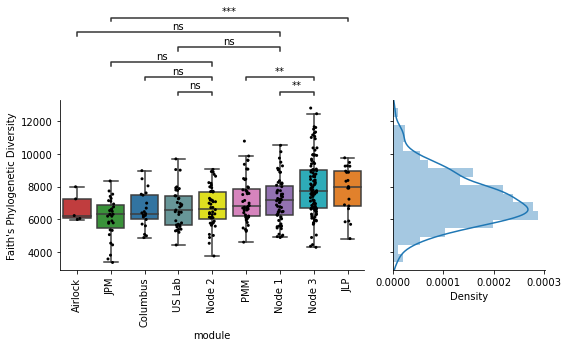

In [37]:
#Fig. S2B
#Alpha diversity figure with stat tests
f, (ax1,ax2) = plt.subplots(ncols=2,figsize=(8,6),gridspec_kw={'width_ratios': [2, 1]},sharey=True)
order_ = alpha_results_df_w_metadata.sort_values(by='faith_pd_median')['module'].unique()
sns.boxplot(x='module', y='faith_pd', order=order_,data=alpha_results_df_w_metadata, fliersize=0,ax=ax1,palette=module_colors)
sns.stripplot(x='module', y='faith_pd', order=order_,data=alpha_results_df_w_metadata,
              size=3,color='black',ax=ax1)

#pairs for stat tests were defined by physical interconnectedness of modules 

pairs = [('JPM','JLP'),('Node 3','PMM'),('Node 2','JPM'),('Node 2','Columbus'),('Node 2','US Lab'),
        ('Node 1','US Lab'),('Airlock','Node 1'),('Node 1','Node 3')]
annot = Annotator(ax1, pairs, data=alpha_results_df_w_metadata, x='module', y='faith_pd', order=order_)
annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction='fdr_bh')
annot.apply_test()
ax1, test_results = annot.annotate()

sns.distplot(alpha_results_df_w_metadata['faith_pd'],ax=ax2,vertical=True)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='center')
labels =ax2.get_xticklabels()
# ax2.set_xticklabels(labels, rotation=45, ha='center')
ax1.set_ylabel('Faith\'s Phylogenetic Diversity')

for ax in (ax1,ax2):
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('./figs/sup_fig_s2_alphadiv_faiths_pd.svg')

In [38]:
alpha_metrics_anova = ['observed_features', 'faith_pd','shannon']
metadata_technical = 'run_prefix + sample_plate + plating'
metadata_biological = 'module + gmt + orientation'

In [39]:
anova_results = {}
for metric in alpha_metrics_anova:
    # lm linear model.
    lm = ols(metric+'~' + '+ '+ metadata_biological + '+ '+ metadata_technical,
                   data=alpha_results_df_w_metadata).fit()
    table = sm.stats.anova_lm(lm, typ=2) 
    anova_results.update({metric:table.sort_values(by='PR(>F)')})


In [40]:
anova_results_df = pd.concat(anova_results, axis=0)

In [41]:
anova_results_df

sum_sq     df          F        PR(>F)
observed_features module        5.033536e+05    8.0  33.449010  2.673736e-39
                  sample_plate  4.906076e+05    8.0  32.602009  1.810017e-38
                  gmt           4.143593e+05    6.0  36.713513  1.102750e-34
                  run_prefix    2.146603e+04    1.0  11.411737  8.093928e-04
                  plating       3.072241e+03    1.0   1.633260  2.020739e-01
                  orientation   5.450888e+03    5.0   0.579559  7.156785e-01
                  Residual      6.790584e+05  361.0        NaN           NaN
faith_pd          sample_plate  9.263858e+08    8.0  60.958571  1.913941e-62
                  module        7.518261e+08    8.0  49.472091  1.393168e-53
                  gmt           5.893031e+08    6.0  51.703549  8.611457e-46
                  run_prefix    4.097113e+07    1.0  21.568049  4.790023e-06
                  plating       8.417172e+06    1.0   4.430973  3.598299e-02
                  orientation   5.812493e+06    5.0   0.611963  6.908049e-01
                  Residual      6.857634e+08  361.0        NaN           NaN
shannon           module        3.253832e+02    8.0  56.975367  1.754609e-59
                  sample_plate  3.059829e+02    8.0  53.578328  7.262295e-57
                  gmt           1.538666e+02    6.0  35.923193  4.709434e-34
                  run_prefix    1.085507e+01    1.0  15.205980  1.149423e-04
                  plating       6.870118e+00    1.0   9.623790  2.072004e-03
                  orientation   7.217026e+00    5.0   2.021949  7.489478e-02
                  Residual      2.577064e+02  361.0        NaN           NaN

In [42]:
anova_results_df.to_csv('./output/table_S1_alphadiv_anova.csv')


# Betadiversity

## RPCA

In [43]:
## Initializing Dictionary with betadiv_ordinations and distace_matrices from different metrics
betadiv_ord = {}
betadiv_dist = {}

In [44]:
deblur_rpca = rpca(gg2_ft)

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [45]:
biplot(deblur_rpca.biplot,sample_metadata=metadata,
       feature_metadata = gg2_feature_metadata,
       number_of_features=65).visualization.save('./output/rpca-biplot_gg2.qzv')

'./output/rpca-biplot_gg2.qzv'

In [46]:
rpca_df = deblur_rpca.biplot.view(skbio.OrdinationResults).samples
#with metadata for plotting
rpca_df_wm = rpca_df.merge(metadata_df,left_index=True,right_index=True)

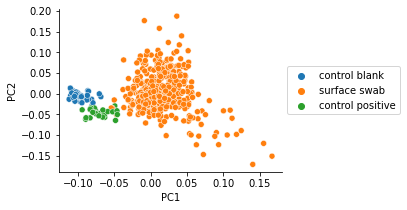

In [47]:
f, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(x=0,y=1,hue='sample_type',data=rpca_df_wm,ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Katharoseq controls and extraction BLANKS where driving clustering and consuming PCA space. Filtering them out.

In [48]:
deblur_gg2_no_controls = filter_samples(gg2_ft,
                                     metadata = metadata,
                                     where= "sample_type == 'surface swab'").filtered_table

In [49]:
deblur_rpca_no_controls = rpca(deblur_gg2_no_controls)

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [50]:
biplot(deblur_rpca_no_controls.biplot,sample_metadata=metadata,
       feature_metadata = gg2_feature_metadata,
       number_of_features=10).visualization.save('./output/rpca-biplot_no_controls_gg2.qzv')

'./output/rpca-biplot_no_controls_gg2.qzv'

In [51]:
deblur_gg2_no_controls.view(Table)

10510 x 393 <class 'biom.table.Table'> with 82086 nonzero entries (1% dense)

In [52]:
deblur_gg2_no_controls.view(pd.DataFrame).sum().sum()

11560821.0

In [53]:
rpca_no_controls_df = deblur_rpca_no_controls.biplot.view(skbio.OrdinationResults).samples
#with metadata for plotting
rpca_no_controls_df_wm = rpca_no_controls_df.merge(metadata_df,left_index=True,right_index=True)

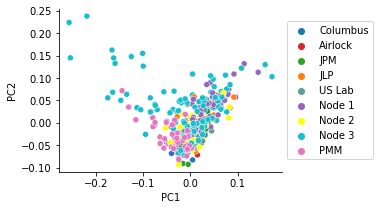

In [54]:
f, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(x=0,y=1,hue='module',palette=module_colors,data=rpca_no_controls_df_wm,ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Some "horseshoe" like spread in the RPCA plot. Feature_table very sparse. Will try rarefying

In [55]:
#Rarefied once and saved to file. 
# deblur_gg2_no_controls_rarefied = rarefy(deblur_gg2_no_controls,
#                             sampling_depth=5000).rarefied_table
# deblur_gg2_no_controls_rarefied.save('./data/katharo_deblur_gg2_feature_table_no_controls_rarefied.qza')
deblur_gg2_no_controls_rarefied = Artifact.load('./data/katharo_deblur_gg2_feature_table_no_controls_rarefied.qza')

In [56]:
#Improved sparsity, but not dramatically
deblur_gg2_no_controls_rarefied.view(Table)

6467 x 384 <class 'biom.table.Table'> with 62076 nonzero entries (2% dense)

In [57]:
deblur_rpca_rarefied = rpca(deblur_gg2_no_controls_rarefied,n_components=5)

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [58]:
biplot(deblur_rpca_rarefied.biplot,
       sample_metadata=metadata,
       feature_metadata = gg2_feature_metadata,
       number_of_features=65).visualization.save('./output/rpca-biplot_no_controls_rarefied_gg2.qzv')

'./output/rpca-biplot_no_controls_rarefied_gg2.qzv'

In [59]:
rpca_rarefied_df = deblur_rpca_rarefied.biplot.view(skbio.OrdinationResults).samples
#with metadata for plotting
rpca_rarefied_df_wm = rpca_rarefied_df.merge(metadata_df,left_index=True,right_index=True)

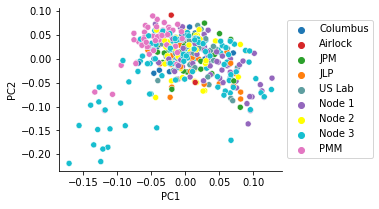

In [60]:
f, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(x=0,y=1,hue='module',palette=module_colors,data=rpca_rarefied_df_wm,ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [61]:
#Store results in dictionary
betadiv_ord.update({'RPCA':deblur_rpca_rarefied.biplot})
betadiv_dist.update({'RPCA':deblur_rpca_rarefied.distance_matrix})

In [62]:
#run RPCA but phylogenetically informed
deblur_phylo_rpca_rarefied = phylogenetic_rpca_with_taxonomy(deblur_gg2_no_controls_rarefied,
                                                             phylogeny=gg2_tree,
                                                             taxonomy=gg2_feature_metadata,
                                                            n_components=5)

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/gemelli/preprocessing.py:423: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(matrix_closure(mat) * branch_lengths))


In [63]:
#Make a feature metadata file for EMPRESS visualization. Stores feature loadings, resolved at tree nodes,
#and feature counts for sOTUS (but not tree nodes)
deblur_phylo_rpca_rarefied_taxonomy = deblur_phylo_rpca_rarefied.t2t_taxonomy.view(Metadata).to_dataframe()
deblur_phylo_rpca_rarefied_taxonomy.index.name = 'featureid'
deblur_phylo_rpca_rarefied_feature_loadings = deblur_phylo_rpca_rarefied.biplot.view(skbio.OrdinationResults).features.rename({0:'PC1',
                                                                                                                         1:"PC2",
                                                                                                                         2:"PC3",
                                                                                                                         3:'PC4',
                                                                                                                         4:'PC5',
#                                                                                                                          5:'PC6',
#                                                                                                                          6:'PC7',
#                                                                                                                          7:'PC8',
#                                                                                                                          8:'PC9',
#                                                                                                                          9:'PC10'
                                                                                                                        },
                                                                                                axis=1)
deblur_phylo_rpca_rarefied_feature_loadings -= deblur_phylo_rpca_rarefied_feature_loadings.mean(0)
deblur_phylo_rpca_rarefied_taxonomy_and_loadings = pd.concat([deblur_phylo_rpca_rarefied_taxonomy,
                                                 deblur_phylo_rpca_rarefied_feature_loadings], axis=1)
deblur_phylo_rpca_rarefied_taxonomy_and_loadings.index.name = 'featureid'
deblur_phylo_rpca_rarefied_taxonomy_and_loadings['log10_counts'] = np.log10(deblur_gg2_no_controls_rarefied.view(pd.DataFrame).sum())
deblur_phylo_rpca_rarefied_taxonomy_and_loadings.head(5)

,Taxon,PC1,PC2,PC3,PC4,PC5,log10_counts
featureid,,,,,,,
n11395,d__; p__; c__; o__; f__; g__; s__,0.000095,0.000061,-0.000050,0.000185,-0.000060,NaN
n11393,d__Bacteria; p__; c__; o__; f__; g__; s__,0.015846,0.002070,-0.015398,0.082411,-0.093957,NaN
n11363,d__Bacteria; p__Patescibacteria; c__; o__; f__...,-0.003064,0.021161,0.015286,0.007319,-0.001592,NaN
n43,d__Bacteria; p__Patescibacteria; c__Saccharimo...,-0.000256,-0.000518,-0.000061,0.000584,-0.000357,NaN
TACGGAGAAGGCAAGCGTTACCCGGAATTACTGGGCGTAAAGCGTTGCGTAGGTGGTCTGTTAAGTGAAGTGCGAAATCCCATGGCTCAACCAAGGGTTGGTATTTCAAACTAGCAGACTAGAGGACAGGAGAGGTGAGTGGAATTCCTG,d__Bacteria; p__Patescibacteria; c__Saccharimo...,-0.000197,-0.000449,0.000294,0.000649,-0.000230,1.176091


In [64]:
biplot(deblur_phylo_rpca_rarefied.biplot,
       sample_metadata=metadata,
       feature_metadata = Metadata(deblur_phylo_rpca_rarefied_taxonomy),
       number_of_features=65).visualization.save('./output/phylo_rpca-biplot_no_controls_rarefied_gg2.qzv')

'./output/phylo_rpca-biplot_no_controls_rarefied_gg2.qzv'

In [65]:
phylo_rpca_rarefied_df = deblur_phylo_rpca_rarefied.biplot.view(skbio.OrdinationResults).samples
#with metadata for plotting
phylo_rpca_rarefied_df_wm = phylo_rpca_rarefied_df.merge(metadata_df,left_index=True,right_index=True)

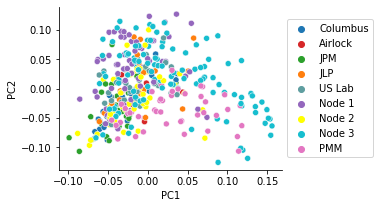

In [66]:
#Fig. 2A. Finalized figure was generated with EMPRESS paired plot generated below. 
f, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(x=0,y=1,hue='module',palette=module_colors,data=phylo_rpca_rarefied_df_wm,ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [67]:
from qiime2.plugins.empress.actions import community_plot

In [68]:
# Filtering Feature space for Tree visualization
deblur_gg2_no_controls_rarefied_filtered = filter_features_conditionally(deblur_gg2_no_controls_rarefied,
                                                   abundance=.0001,
                                                   prevalence=.01).filtered_table

In [69]:
deblur_gg2_no_controls_rarefied.view(Table)

6467 x 384 <class 'biom.table.Table'> with 62076 nonzero entries (2% dense)

In [70]:
#EMPRESS visualization was used for Figures 2A-2B, S2F
#65 features visualized in biplot represent top ~1% (65/6467)of features driving clustering in ordination
#the deblur_gg2_no_controls_rarefied_filtered artufact is used to decrease the amount of leaves in the tree
#for visualization purposes
tree_biplot = community_plot(deblur_phylo_rpca_rarefied.counts_by_node_tree,
                                   deblur_gg2_no_controls_rarefied_filtered,
                                   metadata,
                             deblur_phylo_rpca_rarefied.biplot,
                                   feature_metadata = Metadata(deblur_phylo_rpca_rarefied_taxonomy_and_loadings),
                                   number_of_features=65,
                                   ignore_missing_samples=False,
                                   filter_extra_samples=False,
                                   filter_missing_features=True)
tree_biplot.visualization.save('./output/phylo_rpca_empress_gg2_f.qzv')

'./output/phylo_rpca_empress_gg2_f.qzv'

In [71]:
betadiv_ord.update({'Pylogenetic RPCA':deblur_phylo_rpca_rarefied.biplot})
betadiv_dist.update({'Pylogenetic RPCA':deblur_phylo_rpca_rarefied.distance_matrix})

In [72]:
deblur_phylo_rpca_rarefied.distance_matrix.save('./data/phylo_rpca_distance_matrix.qza')

'./data/phylo_rpca_distance_matrix.qza'

In [73]:
## Ran module_distances.py in slurm

# import qiime2
# from skbio import DistanceMatrix
# import pandas as pd

# fp = './data/phylo_rpca_distance_matrix.qza'

# metadata = qiime2.Metadata.load('./metadata/2023_01_19_3DMM_metadata_from_qita_updated.txt')
# metadata_df = metadata.to_dataframe()

# dm = qiime2.Artifact.load(fp).view(DistanceMatrix)

# results = pd.DataFrame([])

# metadata_df_f=metadata_df.reindex(dm.ids)
# for from_group in metadata_df_f['module'].unique():
#     from_ = metadata_df_f.loc[metadata_df_f['module']==from_group].index
#     for to_group in metadata_df['module'].unique():
#         to_ = metadata_df_f.loc[metadata_df_f['module']==to_group].index
#         o_ = dm.between(from_,to_,allow_overlap=True)
#         o_['metric']='phylo_RPCA'
#         o_['from'] = from_group
#         o_['to'] = to_group
#         results = pd.concat([results,o_])

# results.to_csv('./output/module_distances.csv')

In [74]:
module_distances = pd.read_csv('./output/module_distances.csv')

In [75]:
distances_df = pd.DataFrame()
for module in module_distances['from'].unique():
    distances_ = module_distances.loc[module_distances['from']==module]
    for compare_to in distances_['to'].unique():
        median_ = distances_.loc[distances_['to']==compare_to,'value'].median()
        distances_.loc[distances_['to']==compare_to,'median']=median_
        distances_df = pd.concat([distances_df,distances_[['from','to','median']].drop_duplicates()])

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packag

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packag

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-pa

/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/rodolfoantoniosalidobenitez/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-pa

In [76]:
distances_df = distances_df.loc[~distances_df['median'].isnull()].drop_duplicates()

In [77]:
modules = ['Columbus', 'Airlock', 'JPM', 'JLP', 'US Lab', 'Node 1', 'Node 2','Node 3', 'PMM']
distances_matrix = pd.DataFrame()
for index in modules:
    for column in modules:
        value_ = distances_df.loc[(distances_df['from']==index)&
                                  (distances_df['to']==column),'median']
        distances_matrix.loc[index,column]=float(value_)

In [78]:
phylo_RPCA_stat = beta_group_significance(deblur_phylo_rpca_rarefied.distance_matrix,
                                         metadata.get_column('module'),pairwise=True)

<Figure size 432x288 with 0 Axes>

In [79]:
#Pairwise permanova results table from qiime2 qzv output is Supplementary Table S3
phylo_RPCA_stat.visualization.save('./output/PERMANOVA_table_s3.qzv')

'./output/PERMANOVA_table_s3.qzv'

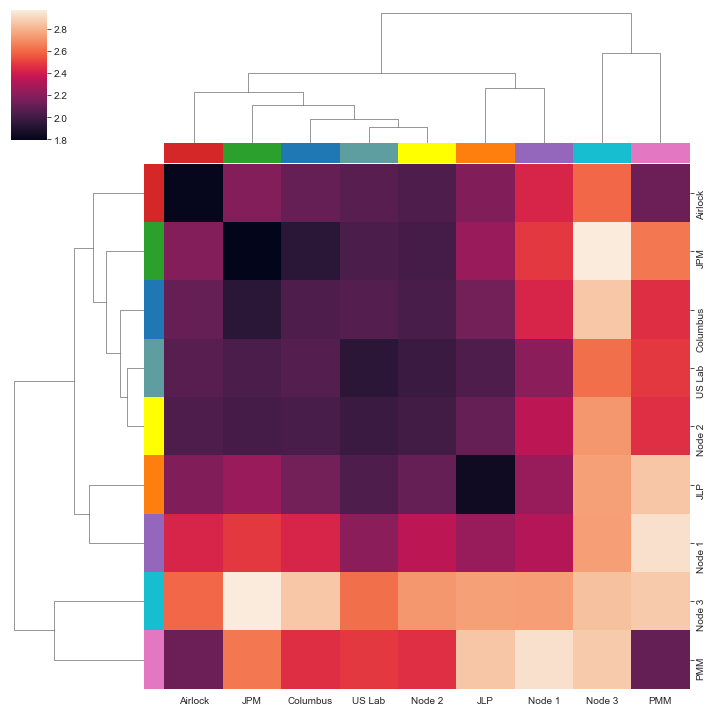

In [80]:
#Fig. S2D. Finalized figure was further annotated with Illustrator. 
#Not significant [n.s.] labels were given to FDR-corrected PERMANOVA tests p-values>0.01 from Table S3.
sns.clustermap(distances_matrix,
               col_colors=distances_matrix.columns.map(module_colors),
               row_colors=distances_matrix.columns.map(module_colors))
plt.savefig('./figs/figure_s2D_heatmap_alt.svg')

In [81]:
def differential_plot(diff_df, level, color_by, x_axis, ax,
                      xtitle='title',
                      cbartitle='cbar legend',
                      quartile_partition=True,
                      upper=.75, lower=.25, cmap_use='RdBu_r',
                      ntfilter=0, ensure_include = [],
                      n_top_bottom_filter=False,
                      n_top_bottom=50):

    # make colormap
    # group level
    diff_df_grouped = diff_df.groupby(level).mean()
    # filter N-total
    keep_ = [k for k,v in dict(diff_df[level].value_counts()).items()
             if v > ntfilter]
    diff_df = diff_df[diff_df[level].isin(keep_)]
    # keep quartiles
    if quartile_partition:
        quant_ = diff_df_grouped[x_axis].quantile([lower, .5, upper]).values
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] < quant_[0]].index)
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] > quant_[-1]].index)
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_ + ensure_include)]
    elif n_top_bottom_filter:  
        diff_df_grouped = diff_df_grouped.sort_values(by=x_axis, ascending=False)
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] > 0].index[:n_top_bottom//2])
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] <= 0].index[-n_top_bottom//2:])
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_)]
    # remove some chars.
    #diff_df[level] = [v_.replace('[','').replace(']','')
    #                  for v_ in diff_df[level]]
    # ordering
    diff_df_grouped = diff_df.groupby(level).mean()
    order_ = diff_df_grouped[x_axis].sort_values(ascending=False).index
    order_ = {j:i for i, j in enumerate(order_)}
    diff_df['sort'] = [order_[v_] for v_ in diff_df[level]]
    # make a colorbar (first get colors by diffs.)
    all_prop = diff_df.groupby(level).mean().fillna('nan')
    coeff_ = all_prop[color_by].to_dict()
    coeff_[np.nan] = np.nan
    # build the cmap
    # plot
    sns.barplot(y=level,
                x=x_axis,
                palette=cmap_use,
                data=diff_df.sort_values('sort'),
                ax=ax,
                ci=95)
    ax.set_ylabel('')
    ax.set_xlabel(xtitle,
                  weight='bold',
                  fontsize=14)
    
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax, diff_df






In [82]:
#extraction taxonomy and feature loading from phylo_rpca results
t2t_df =deblur_phylo_rpca_rarefied.t2t_taxonomy.view(pd.DataFrame) 
t2t_feat_ord = deblur_phylo_rpca_rarefied.biplot.view(OrdinationResults).features.copy()
t2t_feat_ord.columns = ['PC1', 'PC2', 'PC3','PC4','PC5']
#centering feature loadings  around 0 for each Principal Component 
t2t_feat_ord -= t2t_feat_ord.mean(0)
t2t_feat_ord = t2t_feat_ord.merge(t2t_df, left_index=True, right_index=True, how='left')
#splitting taxonomy in ranks
t2t_feat_ord['family']=t2t_feat_ord['Taxon'].str.rsplit(';',n=3).str[-3]
t2t_feat_ord['genus']=t2t_feat_ord['Taxon'].str.rsplit(';',n=2).str[-2]
t2t_feat_ord = t2t_feat_ord.dropna(subset=['PC1'])
t2t_feat_ord = t2t_feat_ord.reindex(deblur_gg2_no_controls_rarefied_filtered.view(pd.DataFrame).columns)

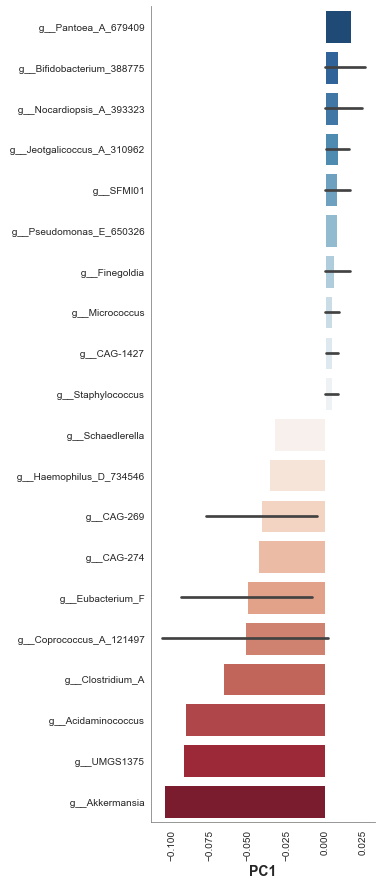

In [83]:
#Fig. S2E
fig, ax = plt.subplots(1, 1, figsize=(4, 15), sharey=False)

ax, df_tmp = differential_plot(t2t_feat_ord, 'genus', 'PC1', 'PC1',
                   ax, 
                    #upper=.75, lower=.25,
                               ntfilter=0,cmap_use='RdBu_r',
                   xtitle='PC1', quartile_partition=False,
                  n_top_bottom_filter=True, n_top_bottom=20)
plt.xticks(rotation=90)
plt.savefig('./output/phylo_RPCA_PC1_genus.png',dpi=300)

In [84]:
## saving to ordinations file to run RDA-ANOVA on Command Line Interface
for metric, ord_ in betadiv_ord.items():
    ord_.save('./data/'+metric.replace(' ','').replace('-','')+'_ordination.qza')

In [85]:
# ran run_RDA.py in slurm

# import glob
# import pandas as pd
# from biom import Table, load_table
# from qiime2 import Artifact
# from assets.step_wise_anova import run_stepwise_anova
# from skbio import OrdinationResults, TreeNode, DistanceMatrix

# # Perform stepwise RDA-ANOVA
# RDA_dict = {}
# metadata_categories_to_test = ['run_prefix','sample_plate','plating','module','gmt','orientation']

# #Load q2 artifacts
# deblur_betadiv_no_controls_rarefied = Artifact.load('./data/katharo_deblur_gg2_feature_table_no_controls_rarefied.qza')
# betadiv_ord_ = {}
# for file in glob.glob('./data/*ordination.qza'):
#     q2_artifact = Artifact.load(file)
#     metric = file.replace('./data/','').replace('_ordination.qza','')
#     betadiv_ord_.update({metric:q2_artifact})
    
# # Clean up meta (only stuff to run)
# keep_ = deblur_betadiv_no_controls_rarefied.view(pd.DataFrame).index
# metadata_RDA = pd.read_csv('./metadata/2023_03_21_3DMM_metadata_to_update_qiita.txt',sep='\t')
# metadata_RDA = metadata_RDA.set_index('#SampleID').reindex(keep_)

# # Run stepwise ANOVA for all RDA ordinations
# for metric_, ord_ in  betadiv_ord_.items():
#     # get first three axes
#     ord_ = ord_.view(OrdinationResults).samples[[0,1,2]]
#     ord_.columns = ['PC1','PC2','PC3']
#     # subset/match
#     mf_ord_ = metadata_RDA.copy()
#     shared_ids = list(set(ord_.index)\
#                       & set(mf_ord_.index))
#     mf_ord_ = mf_ord_.loc[shared_ids,:]
#     ord_ = ord_.loc[shared_ids,:]
#     RDA_dict[metric_] = run_stepwise_anova(ord_, mf_ord_, metadata_categories_to_test) #mf_ord_.columns)

# # Concat output from all runs and export
# RDA_results_df = pd.concat(RDA_dict, axis=0)
# RDA_results_df.to_csv('./output/2024_rda_results_df.csv')

In [86]:
rda_results_df = pd.read_csv('./output/2024_rda_results_df.csv').rename(columns={'Unnamed: 0':'BetaDiv Metric',
                                                                           'Unnamed: 1':'Metadata Category'})

In [87]:
rda_results_df = rda_results_df.set_index(['BetaDiv Metric','Metadata Category']).sort_values(by=['BetaDiv Metric','R2.adj'],
                                                                            ascending=False)

In [88]:
rda_results_df

R2.adj  Df         AIC          F  \
BetaDiv Metric  Metadata Category                                        
RPCA            + module           0.194930   8  347.498709  12.591888   
                + orientation      0.028409   5  338.548784   3.743415   
                + sample_plate     0.018098   8  337.100779   2.103474   
                + gmt              0.005410   1  335.290287   3.600092   
PylogeneticRPCA + module           0.184887   8  352.259305  11.859205   
                + sample_plate     0.023480   8  348.754667   2.390337   
                + orientation      0.019542   5  343.888968   2.857763   
                + gmt              0.004653   1  342.505762   3.194619   

                                     Pr(>F)  
BetaDiv Metric  Metadata Category            
RPCA            + module           0.000200  
                + orientation      0.000200  
                + sample_plate     0.002200  
                + gmt              0.015397  
PylogeneticRPCA + module           0.000200  
                + sample_plate     0.000200  
                + orientation      0.000400  
                + gmt              0.026795

In [89]:
#For Supplementary Table (Table S2), we only reported on RPCA 
rda_results_df.to_csv('./output/table_s2_betadiv_RDA.csv')

In [91]:
from dataclasses import dataclass
from matplotlib_venn import venn3

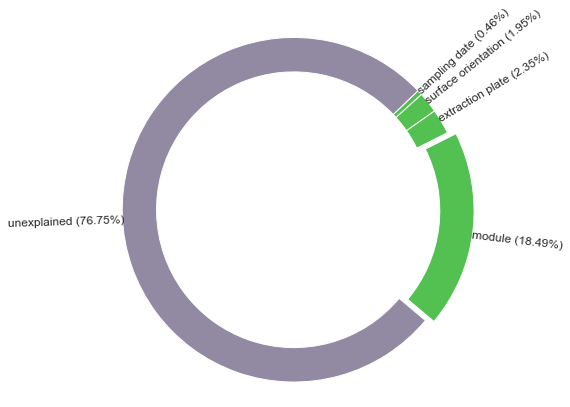

In [92]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ' module (18.49%)','extraction plate (2.35%)','surface orientation (1.95%)',\
'sampling date (0.46%)','unexplained (76.75%) '
sizes = [18.49,2.35,1.95,0.46, (100-18.49-2.35-1.95-0.46)]
explode = (0.05,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#52c151','#52c151','#52c151','#52c151','#918aa2']

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, colors=colors,labeldistance=.97,autopct=None, startangle=320,
        rotatelabels=True,textprops={'fontsize':12,
                                    'weight':'regular'},
        wedgeprops=dict(width=0.2))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('./output/rda.svg')

# Phylogenetic tree viz

In [93]:
gg2_taxonomy_df['phylum']=gg2_taxonomy_df['Taxon'].str.rsplit(';',n=6).str[-6]
gg2_taxonomy_df['class']=gg2_taxonomy_df['Taxon'].str.rsplit(';',n=6).str[-5]
gg2_taxonomy_df['order']=gg2_taxonomy_df['Taxon'].str.rsplit(';',n=6).str[-4]
gg2_taxonomy_df['family']=gg2_taxonomy_df['Taxon'].str.rsplit(';',n=6).str[-3]
gg2_taxonomy_df['genus']=gg2_taxonomy_df['Taxon'].str.rsplit(';',n=6).str[-2]
gg2_taxonomy_df['species']=gg2_taxonomy_df['Taxon'].str.rsplit(';',n=6).str[-1]

In [94]:
gg2_taxonomy_df['domain']=gg2_taxonomy_df['Taxon'].str.rsplit(';',n=6).str[-7]

In [95]:
feature_table_with_taxonomy = pd.DataFrame(index=pd.MultiIndex.from_frame(gg2_taxonomy_df.reset_index()[['domain','phylum','class',
                                                        'order','family','genus',
                                                        'species','Feature ID']])).merge(deblur_gg2_no_controls_rarefied.view(pd.DataFrame).T,
                                                                                         left_on='Feature ID',right_index=True,how='right')

In [96]:
top_5 = deblur_gg2_no_controls_rarefied.view(pd.DataFrame).sum().sort_values().tail(5).index

In [97]:
gg2_taxonomy_df.loc[gg2_taxonomy_df.index.isin(top_5),:]

,Taxon,Confidence,phylum,class,order,family,genus,species,domain
Feature ID,,,,,,,,,
TACGTAGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCACGTCGTCTGTGAAATCCTAGGGCTTAACCCTGGACGTGCAGGCGATACGGGCTGACTTGAGTACTACAGGGGAGACTGGAATTTCTGG,d__Bacteria; p__Actinobacteriota; c__Actinomyc...,1.0,p__Actinobacteriota,c__Actinomycetia,o__Mycobacteriales,f__Mycobacteriaceae,g__Lawsonella,s__Lawsonella clevelandensis,d__Bacteria
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGG,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.0,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A_737866,f__Enterobacteriaceae_A,g__Pantoea_A_679409,s__Pantoea septica,d__Bacteria
TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGAAAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCATG,d__Bacteria; p__Firmicutes_D; c__Bacilli; o__S...,1.0,p__Firmicutes_D,c__Bacilli,o__Staphylococcales,f__Staphylococcaceae,g__Staphylococcus,s__Staphylococcus caprae,d__Bacteria
TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGCTCATTAAGTCACATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATGTGATACTGGTGGTGCTAGAATATGTGAGAGGGAAGTAGAATTCCAG,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.0,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales_660879,f__Moraxellaceae,g__,s__,d__Bacteria
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCAAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTG,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.0,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales_650611,f__Pseudomonadaceae,g__Pseudomonas_O_647615,s__Pseudomonas_O_647615 parafulva,d__Bacteria


In [98]:
feature_table_with_taxonomy.to_csv('./output/supplementary_data_s2_sOTUs_with_taxonomy.csv')